# ```sampley``` exemplar: the point approach
Before going through this exemplar, please consult the Introduction to sampley exemplars (```intro.ipynb```).
<br>This exemplar illustrates an application of the point approach to data contained within a single file (```trackpoints.csv```) containing continuous datapoints (i.e., datapoints recorded at frequent, regular intervals) that can be joined to construct survey tracks.
<br>It differs from the standard point exemplar as having continuous datapoints allows for certain procedures to be applied in Stage 3 that may be more efficient and precise.

## Setup

### Import the package

In [1]:
from sampley import *

### Set the input folder
To run this exemplar, download the mock data files, put them in a folder, and set the path to the folder below.

In [2]:
input_folder = './input/'

### Set the output folder
To run this exemplar, make a folder to save the outputs in and set the path to the folder below.

In [3]:
output_folder = './output/'

## Stage 1
In Stage 1, we import a single file (```trackpoints.csv```) to make a ```DataPoints``` object, from which we then make a ```Sections``` object.
<br>Although we use a CSV file in this exemplar, there are other options for file types (including XLSX, GPKG, and SHP files). Please see the Stage 1 exemplar (```stage-1.ipynb```) in the horizontal exemplars folder or the User Manual for more details. Note that, regardless of the input file type, once any ```DataPoints``` and/or ```Sections``` objects have been made, the subsequent processing will be the same.

In [4]:
u_trackpoints = DataPoints.from_file(
    filepath=input_folder+'trackpoints.csv',
    x_col='lon',
    y_col='lat',
    crs_input='EPSG:4326',
    crs_working='EPSG:32619',
    datetime_col='datetime',
    tz_input='UTC-05:00',
    section_id_col='section_id'  
)

Success: file successfully input.
Success: x and y (lon/lat) coordinates successfully parsed.
Success: reprojected to CRS 'EPSG:32619'
Success: the column 'datetime' successfully reformatted to datetimes.
Success: the timezone of column 'datetime' successfully set to 'UTC-05:00'.
Success: datapoint IDs successfully generated.


In [5]:
u_sections = Sections.from_datapoints(datapoints=u_trackpoints)

## Stage 2
In Stage 2, we use the ```DataPoints``` object containing sightings data to make a ```Presences``` object which we thin with a spatial threshold of 10000 m and a temporal threshold of 5 days.
<br>Then, we use that ```Presences``` object and the ```Sections``` object to make an ```AbsenceLines``` object with the same thresholds.
<br>Finally, we use the ```AbsenceLines``` object to make an ```Absences``` object which we also thin with the same thresholds.

In [6]:
u_presences = Presences.delimit(
    datapoints=u_trackpoints,
    presence_col='individuals')
u_presences.thin(
    sp_threshold=10000,
    tm_threshold=5,
    tm_unit='day')

In [7]:
u_presences.full  # print the presences GeoDataFrame

,point_id,point,date,datapoint_id
0,p01,POINT (579166.78 4742872.701),2019-01-25,d0004
1,p02,POINT (554184.217 4742741.886),2019-01-25,d0068
2,p03,POINT (548599.876 4742700.214),2019-01-25,d0082
3,p04,POINT (520909.741 4714855.058),2019-02-02,d0480
4,p05,POINT (532548.249 4714899.835),2019-02-02,d0510
5,p06,POINT (512817.407 4705582.465),2019-02-02,d0910
6,p07,POINT (504710.41 4705553.392),2019-02-02,d0930
7,p08,POINT (654449.136 4716189.584),2019-02-05,d1306
8,p09,POINT (645666.237 4716110.937),2019-02-05,d1330
9,p10,POINT (643532.681 4716066.52),2019-02-05,d1336


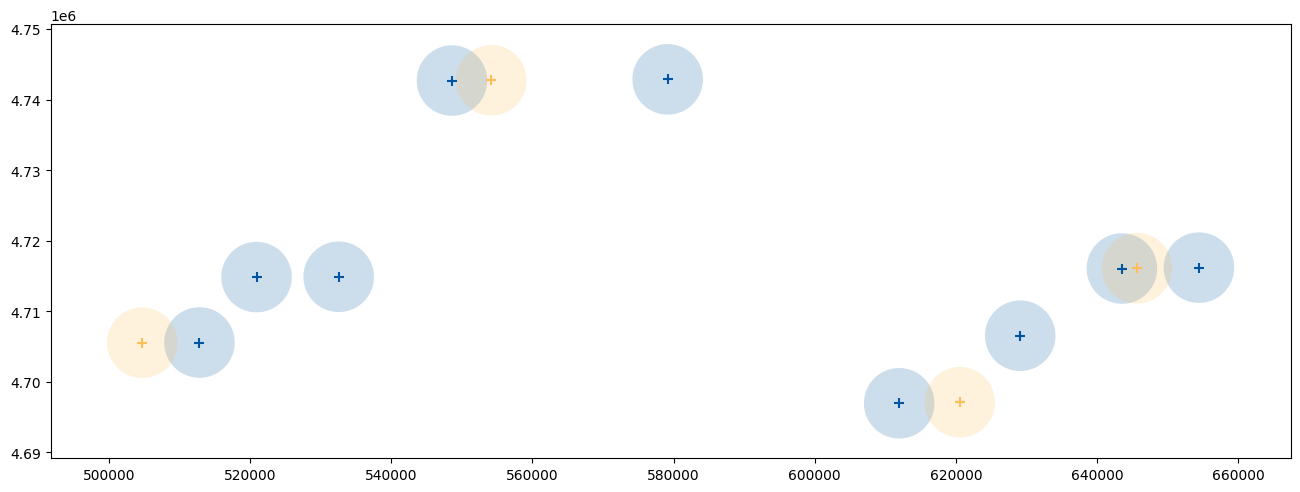

In [8]:
u_presences.plot(which='thinned', sp_threshold=10000)  # plot the presences with their spatial threshold (those kept after thinning in blue, those removed in yellow)

In [9]:
u_absencelines = AbsenceLines.delimit(
    sections=u_sections,
    presences=u_presences,
    sp_threshold=10000,
    tm_threshold=5,
    tm_unit='day',
)

Note: absence lines to be generated with a temporal threshold of 5 day(s).


In [10]:
u_absencelines.absencelines  # print the absence lines GeoDataFrame

,section_id,date,absencelines,presencezones
0,s001,2019-01-25,"MULTILINESTRING ((569169.341 4742820.563, 5691...","MULTIPOLYGON (((589166.78 4742872.701, 589118...."
1,s002,2019-03-03,"LINESTRING (592927.566 4733678.432, 592818.466...",None
2,s003,2019-02-02,"MULTILINESTRING ((500383.195 4714750.316, 5007...","MULTIPOLYGON (((616117.835 4706064.327, 616733..."
3,s004,2019-02-05,"MULTILINESTRING ((656499.299 4751214.73, 65650...","MULTIPOLYGON (((616117.835 4706064.327, 616733..."


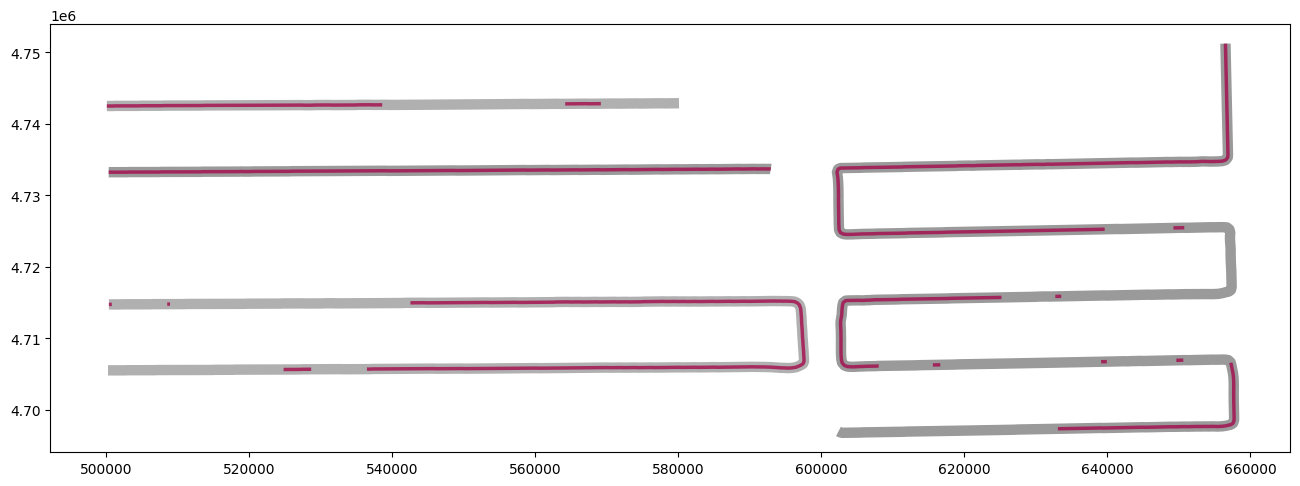

In [11]:
u_absencelines.plot(sections=u_sections)  # plot the absence lines (in red) over the sections (in grey) - note the 'gaps' where survey track was removed due to overlap with the presences

In [12]:
u_absences = Absences.delimit(
    absencelines=u_absencelines,
    var='along',
    target=20,
    dfls=None)
u_absences.thin(
    sp_threshold=10000,
    tm_threshold=5,
    tm_unit='day',
    target=9)

In [13]:
u_absences.full  # print the absences GeoDataFrame

,point_id,point,date
0,a01,POINT (527358.129 4742617.873),2019-01-25
1,a02,POINT (502514.569 4742511.43),2019-01-25
2,a03,POINT (542688.362 4714973.621),2019-02-02
3,a04,POINT (553337.164 4715025.862),2019-02-02
4,a05,POINT (554168.945 4715017.006),2019-02-02
5,a06,POINT (581398.864 4715152.758),2019-02-02
6,a07,POINT (584155.321 4715166.722),2019-02-02
7,a08,POINT (538467.032 4705732.382),2019-02-02
8,a09,POINT (650735.021 4734679.328),2019-02-05
9,a10,POINT (644473.155 4734583.255),2019-02-05


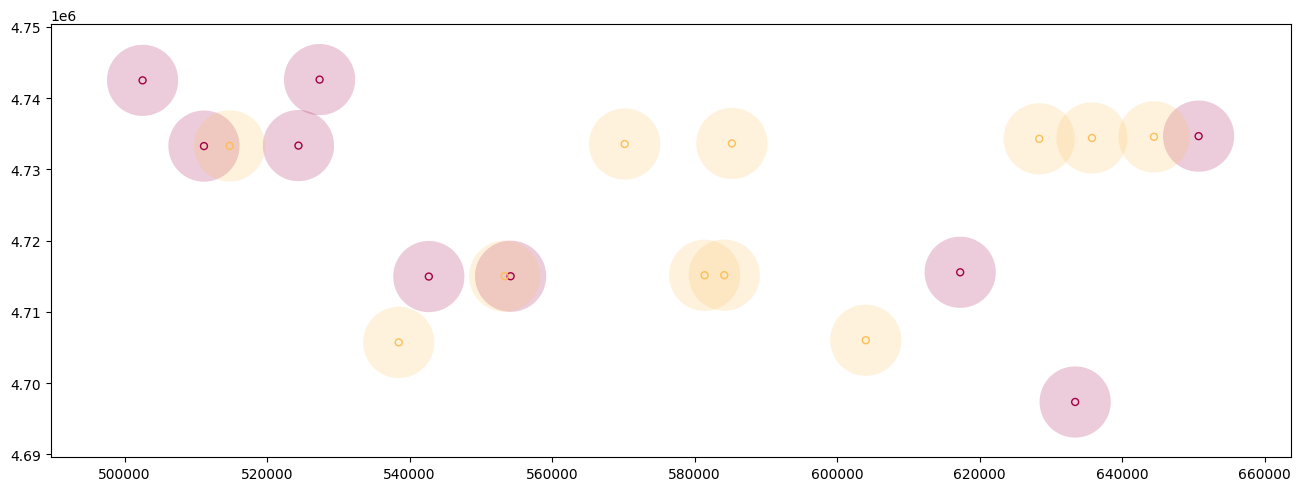

In [14]:
u_absences.plot(which='thinned', sp_threshold=10000)  # plot the absences with their spatial threshold (those kept after thinning in red, those removed in yellow)

## Stage 3
In Stage 3, we make a ```Samples``` object from the ```DataPoints``` object, the ```Presences``` object, the ```Absences``` object, and the ```Sections``` object.
<br>_Note that, as the absence lines are made from sections that are made from datapoints, we can match those datapoints to the absences by their distance from the beginning of the absences lines in order to give values to the absences. To do so we must input the sections (```sections=u_sections```)._

In [15]:
u_samples = Samples.point(
    datapoints=u_trackpoints,
    presences=u_presences,
    absences=u_absences,
    cols=['individuals', 'bss'],
    sections=u_sections)

## Output
Finally, we save the ```Samples``` object to the output folder.

In [16]:
u_samples.save(
    folder=output_folder,
    filetype='csv'
)

In the output folder, there should be two new CSVs: the first should have the same name as the ```Samples``` object (run the box below to see the name) while the second should also have this name but with ```-parameters``` added at the end.

In [17]:
u_samples.name

'samples-presences-trackpoints-+-absences-a-10000m-5day'

The first CSV should contain the samples, like those shown in the box below. 
<br>In this dataframe, each row represents a given presence or absence, i.e., a sample. 
<br>The column ```point``` delimits the location of the presence/absence.
<br>At the end are the data columns. In this particular example, they are ```p-a``` (presence-absence), ```individuals```, and ```bss```.

In [18]:
u_samples.samples

,point_id,point,date,datapoint_id,p-a,individuals,bss
0,p01,POINT (579166.78 4742872.701),2019-01-25,d0004,1,1.0,2
1,p03,POINT (548599.876 4742700.214),2019-01-25,d0082,1,5.0,2
2,p04,POINT (520909.741 4714855.058),2019-02-02,d0480,1,1.0,1
3,p05,POINT (532548.249 4714899.835),2019-02-02,d0510,1,2.0,1
4,p06,POINT (512817.407 4705582.465),2019-02-02,d0910,1,1.0,1
5,p08,POINT (654449.136 4716189.584),2019-02-05,d1306,1,5.0,1
6,p10,POINT (643532.681 4716066.52),2019-02-05,d1336,1,1.0,2
7,p11,POINT (629124.489 4706545.106),2019-02-05,d1527,1,3.0,2
8,p13,POINT (611976.857 4696974.111),2019-02-05,d1739,1,4.0,3
9,a01,POINT (527358.129 4742617.873),2019-01-25,d0135,0,NaN,3


The second CSV should contain the parameters, like those shown in the box below (but arranged in a table). This information may prove useful if, later, we need to know  how the samples were generated.

In [19]:
u_samples.parameters

{'approach': 'point',
 'resampled': 'datapoints',
 'presences_name': 'presences-trackpoints',
 'presences_crs': 'EPSG:32619',
 'presences_sp_threshold': 10000,
 'presences_tm_threshold': 5,
 'presences_tm_unit': 'day',
 'absences_name': 'absences-a-10000m-5day',
 'absences_var': 'along',
 'absences_target': 20,
 'absences_crs': 'EPSG:32619',
 'absences_sp_threshold': 10000,
 'absences_tm_threshold': 5,
 'absences_tm_unit': 'day'}